In [1]:
%cd ..

import os
import torch
import copy
import numpy as np
import pickle
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from PIL import Image

from utils import image_normalization
from dataset import Vanilla
from alignment.alignment_utils import load_deep_jscc
from alignment.alignment_model import AlignedDeepJSCC
from alignment.alignment_training import *
from alignment.alignment_validation import *

/home/lorenzo/repos/Deep-JSCC-PyTorch


/home/lorenzo/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoders_folder = r'alignment/models/autoencoders'
plot_folder = "all_models"
os.makedirs(r'alignment/models/plots/'+plot_folder, exist_ok=True)
os.makedirs(r'alignment/models/plots/'+plot_folder+r'/images', exist_ok=True)

dataset = "cifar10"
resolution = 96
n_samples = 10000
batch_size = 64
num_workers = 4

c = 8
types = ["conv", "neural", "zeroshot", "linear", "unaligned", "no_mismatch"]
snrs = [-20, -10, 0, 10, 20, 30]
seeds = [42, 43]
seed = 42

upscale_factor = 4
image_path = r'demo/kodim23.png'

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
############
# GET DATA #
############

if dataset == 'cifar10':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.CIFAR10(root='../dataset/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.CIFAR10(root='../dataset/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenet':
    # the size of paper is 128
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    print("loading data of imagenet")

    train_dataset = datasets.ImageFolder(root='./dataset/ImageNet/train', transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = Vanilla(root='./dataset/ImageNet/val', transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenette':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.Imagenette(root='../dataset/', split="train", download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.Imagenette(root='../dataset/', split="val", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

else:
    raise Exception('Unknown dataset')

# Train

In [ ]:
for snr in snrs:
    model1_fp = autoencoders_folder + r'/snr_' + str(snr) + r'_seed_' + str(seeds[0]) + r'.pkl'
    model2_fp = autoencoders_folder + r'/snr_' + str(snr) + r'_seed_' + str(seeds[1]) + r'.pkl'

    flat_data = load_alignment_dataset(model1_fp, model2_fp, snr, train_loader, c, device, flat=True)
    data = load_alignment_dataset(model1_fp, model2_fp, snr, train_loader, c, device, flat=False)

    set_seed(seed)
    permutation = torch.randperm(len(data))

    # linear
    aligner = train_linear_aligner(flat_data, permutation, n_samples)
    with open(r'alignment/models/plots/'+plot_folder+'/aligner_linear_'+str(snr)+'.pkl', 'wb') as f:
        pickle.dump(aligner, f)

    # neural
    aligner, epoch = train_neural_aligner(data, permutation, n_samples, batch_size, resolution, 6, snr, device)
    with open(r'alignment/models/plots/'+plot_folder+'/aligner_neural_'+str(snr)+'.pkl', 'wb') as f:
        pickle.dump(aligner, f)

    # conv
    aligner, epoch = train_conv_aligner(data, permutation, n_samples, c, batch_size, snr, device)
    with open(r'alignment/models/plots/'+plot_folder+'/aligner_conv_'+str(snr)+'.pkl', 'wb') as f:
        pickle.dump(aligner, f)

    # zeroshot
    aligner = train_zeroshot_aligner(flat_data, permutation, n_samples, resolution, snr, seed)
    with open(r'alignment/models/plots/'+plot_folder+'/aligner_zeroshot_'+str(snr)+'.pkl', 'wb') as f:
        pickle.dump(aligner, f)

    print(f"Done with {snr}.")

Computing model outputs: 100%|██████████| 782/782 [00:09<00:00, 79.70it/s] 


# Plot

In [ ]:
for snr in snrs:
    model1_fp = autoencoders_folder + r'/snr_' + str(snr) + r'_seed_' + str(seeds[0])
    model2_fp = autoencoders_folder + r'/snr_' + str(snr) + r'_seed_' + str(seeds[1])

    encoder = copy.deepcopy(load_deep_jscc(model1_fp, snr, c, "AWGN").encoder)
    decoder = copy.deepcopy(load_deep_jscc(model2_fp, snr, c, "AWGN").decoder)

    for type in types:
        aligner_fp = r'alignment/models/plots/'+plot_folder+'/aligner_'+type+'_'+str(snr)+'.pkl'
        output_path = r'alignment/models/plots/'+plot_folder+'/images/'+type+'_'+str(snr)+'.png'

        if type == "unaligned":
            aligned_model = AlignedDeepJSCC(encoder, decoder, None, snr, "AWGN")

        elif type == "no_mismatch":
            aligned_model = AlignedDeepJSCC(encoder, copy.deepcopy(load_deep_jscc(model1_fp, snr, c, "AWGN").decoder), aligner, snr, "AWGN")    
        
        else:
            with open(aligner_fp, 'rb') as f:
                aligner = pickle.load(f)

            aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, "AWGN")

        get_image_aligner(aligned_model, image_path, output_path, resolution, upscale_factor)

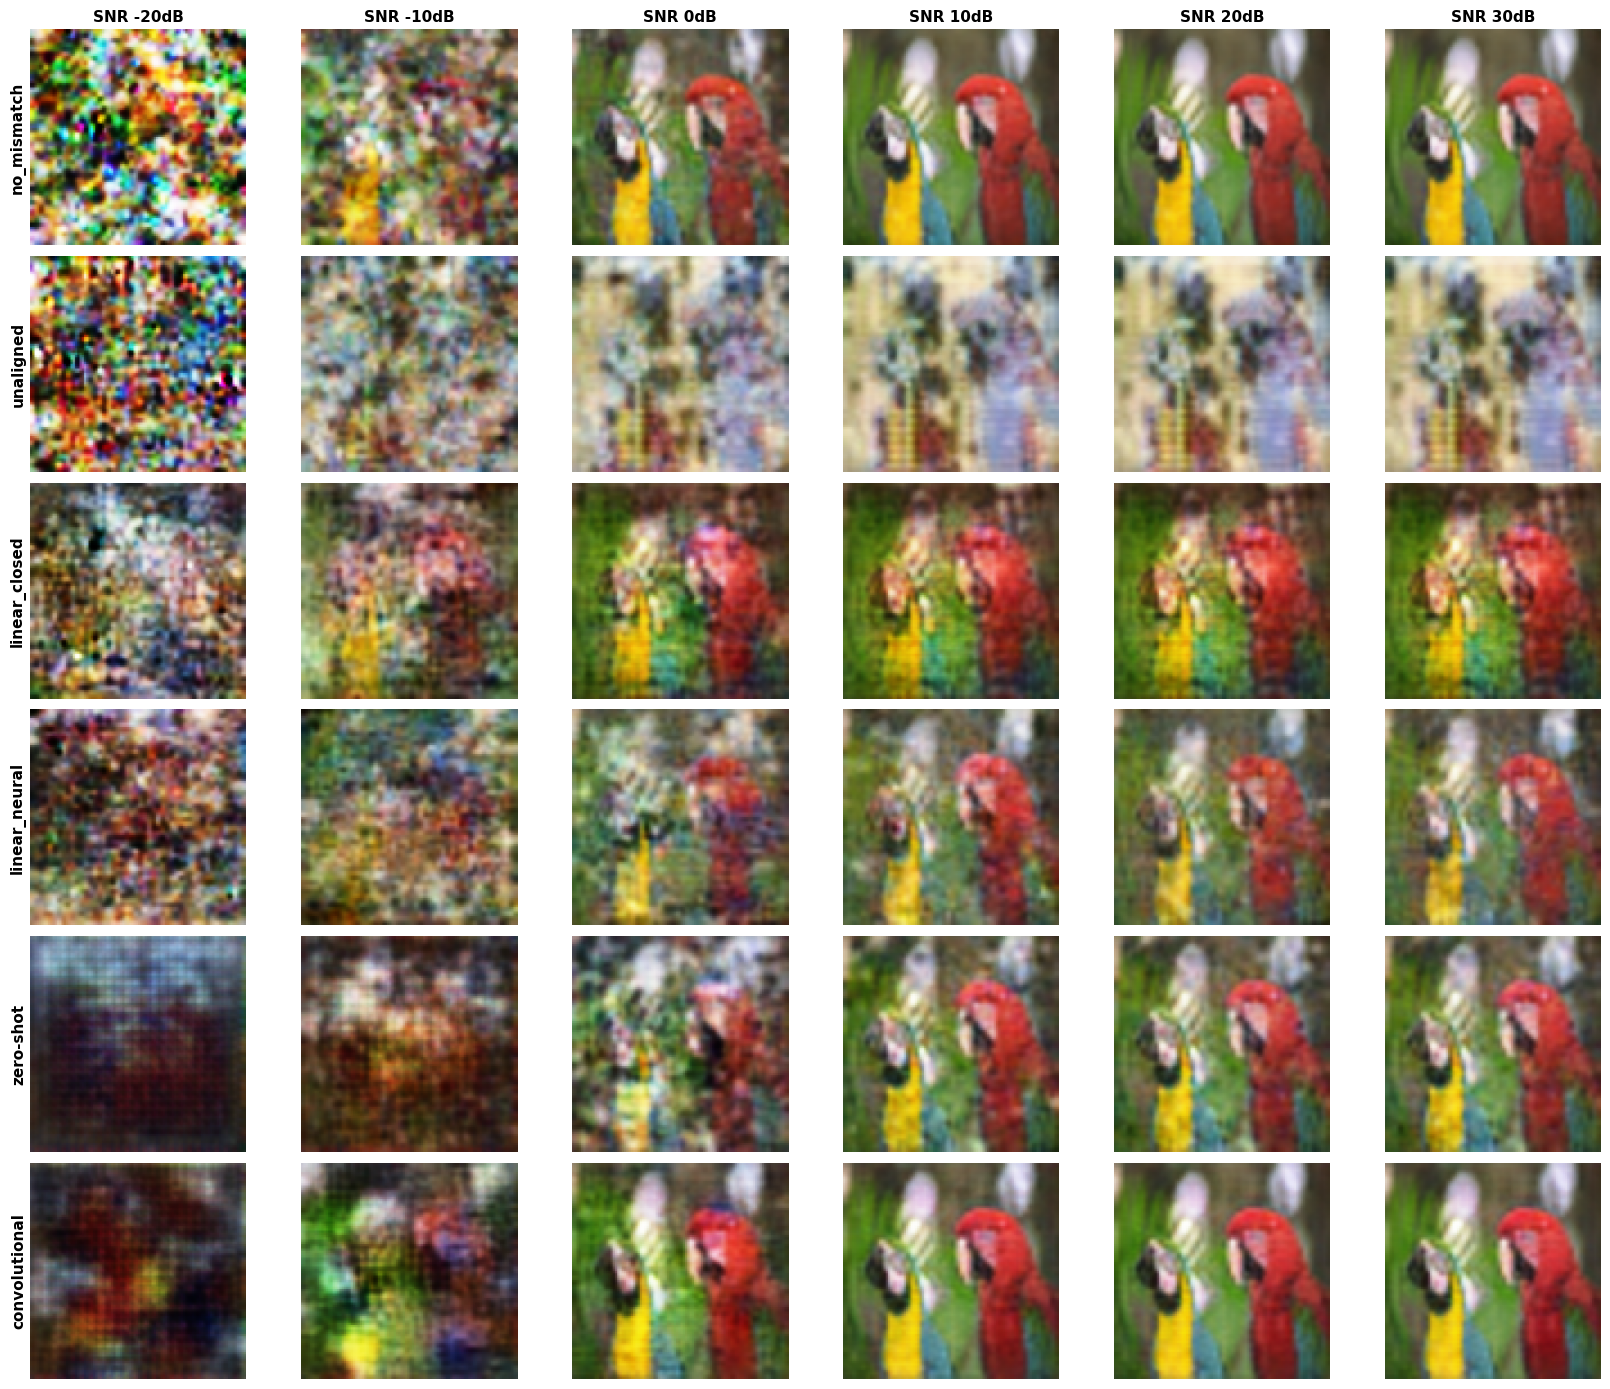

In [ ]:
# Set parameters 
num_rows = 6 
num_cols = 6 
batch_size = num_rows * num_cols 

# Class names and custom headers 
row_titles = ["no_mismatch", "unaligned", "linear_closed", "linear_neural", "zero-shot", "convolutional"] 
row_path = ["no_mismatch", "unaligned", "linear", "neural", "zeroshot", "conv"] 
col_titles = ["SNR -20dB", "SNR -10dB", "SNR 0dB", "SNR 10dB", "SNR 20dB", "SNR 30dB"] 
col_path = ["-20", "-10", "0", "10", "20", "30"] 

# Create figure with minimal spacing
fig, axes = plt.subplots(num_rows, num_cols, 
                        figsize=(18, 15),  # Larger figure for better visibility
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.02})  # Minimal spacing

# Ensure axes is always 2D array
axes = np.atleast_2d(axes)
if axes.shape[0] == 1 and num_rows > 1:
    axes = axes.T

for i in range(num_rows): 
    for j in range(num_cols): 
        image_path = r'alignment/models/plots/'+plot_folder+'/images/' + row_path[i] + "_" + col_path[j] + ".png" 
        
        ax = axes[i, j] if num_rows > 1 else axes[0, j]
        
        try:
            img = Image.open(image_path).convert('RGB') 
            ax.imshow(img) 
            
        except FileNotFoundError:
            # Create placeholder for missing images
            ax.text(0.5, 0.5, f'Missing:\n{row_path[i]}_{col_path[j]}', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=8, bbox=dict(boxstyle='round', facecolor='lightgray'))
        
        # Remove all ticks and spines for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Add column headers on top row
        if i == 0:
            ax.text(0.5, 1.02, col_titles[j], ha='center', va='bottom',  
                   transform=ax.transAxes, fontsize=11, fontweight='bold')
        
        # Add row headers on left column
        if j == 0:
            ax.text(-0.02, 0.5, row_titles[i], ha='right', va='center',
                   transform=ax.transAxes, fontsize=11, fontweight='bold', 
                   rotation=90)

# Remove extra whitespace
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.02, 
                   hspace=0.05, wspace=0.02)

plt.show()